In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Install necessary libraries
!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
class DamageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'imageDamage')
        self.fine_damage_dir = os.path.join(root_dir, 'FineDamageReducedPNG')
        self.coarse_damage_dir = os.path.join(root_dir, 'CoarseDamagePNG')
        self.image_list = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        fine_damage_path = os.path.join(self.fine_damage_dir, img_name.replace('.jpg', '.png'))
        coarse_damage_path = os.path.join(self.coarse_damage_dir, img_name.replace('.jpg', '.png'))

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Load fine and coarse damage annotations as masks
        fine_damage_mask = Image.open(fine_damage_path).convert('L')
        coarse_damage_mask = Image.open(coarse_damage_path).convert('L')

        # Combine fine and coarse damage masks using the sum
        combined_mask = torch.Tensor(np.array(fine_damage_mask)) + torch.Tensor(np.array(coarse_damage_mask))

        # Convert class labels to integers in the combined mask
        class_mapping = {
            'No': 0,
            'Scratches': 1,
            'Grooves/Joints': 2,
            'Cables': 3,
            'Filled Cracks': 4,
            'Cracks': 5,
            'Exposed Rebar': 6,
            'Shadows': 7,
            'Dirt': 8,
            'Vegetative Growth': 9,
            'Debris': 10,
            'Marks': 11,
            'Spalling': 12,
            'Voids': 13
        }

        for label, value in class_mapping.items():
            combined_mask[combined_mask == value] = class_mapping[label]

        # Normalize the combined mask to be in the range [0, 1]
        combined_mask = combined_mask / 13.0  # Assuming 13 is the maximum class label

        # Apply necessary transformations
        transform_img = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        transform_mask = transforms.Compose([
            transforms.ToPILImage(),  # Convert to PIL Image before Resize
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        img = transform_img(img)
        combined_mask = transform_mask(combined_mask.unsqueeze(0))  # Add batch dimension for interpolation
        combined_mask = combined_mask.squeeze(0).unsqueeze(0)

        return img, combined_mask

# Instantiate the dataset and dataloader
dataset = DamageDataset('/content/gdrive/My Drive/project DL/')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the ResNet18-based model for semantic segmentation
class DamageSegmentationModel(nn.Module):
    def __init__(self):
        super(DamageSegmentationModel, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2])
        self.decoder = nn.Conv2d(512, 1, kernel_size=1)  # One output channel

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        return x

# Instantiate the model, loss function, and optimizer
model = DamageSegmentationModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # Calculate BCE loss for the sum of fine and coarse predictions
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.3MB/s]


Epoch [1/1], Loss: 0.3272


In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/gdrive/My Drive/project DL/model-max-2_state.pth')

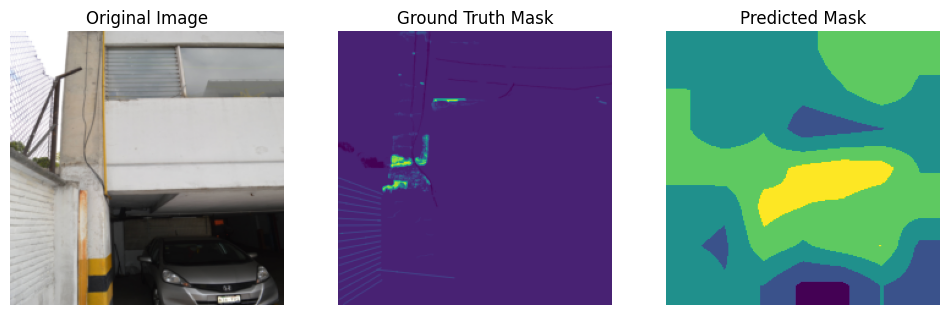

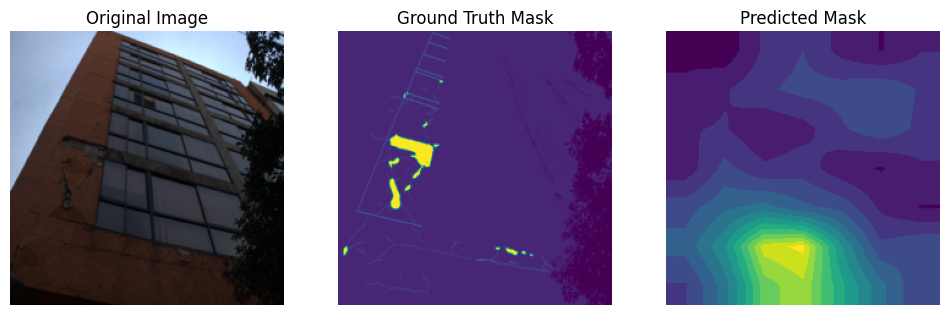

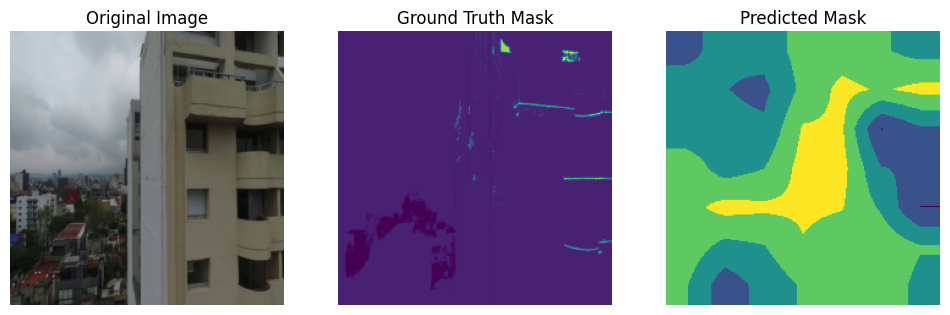

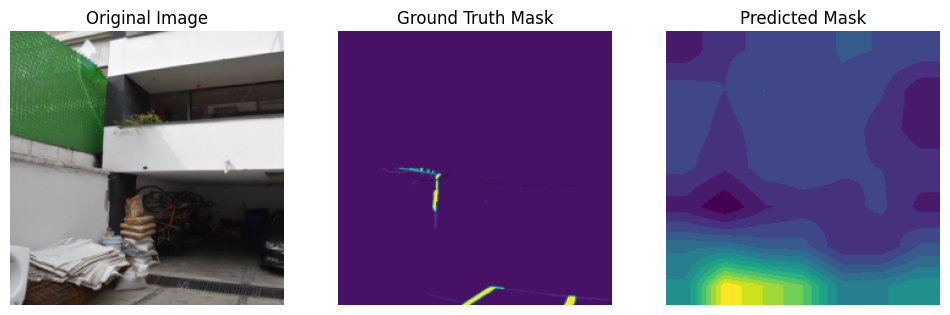

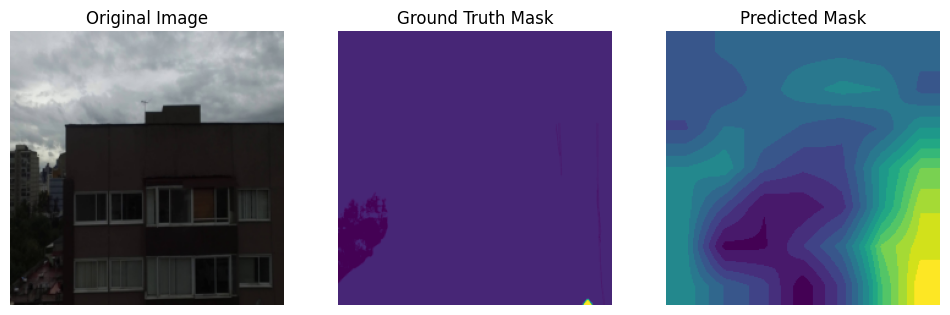

In [ ]:
import torchvision.transforms.functional as TF

# Load the trained model
model = DamageSegmentationModel()
model.load_state_dict(torch.load('/content/gdrive/My Drive/project DL/model-max-2_state.pth'))
model.eval()
model.to(device)  # Move the model to the same device as the input data

# Function to generate predictions and create comparison plots
def generate_and_plot_images(model, dataloader, num_images=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Select random images from the dataset
    indices = np.random.choice(len(dataloader.dataset), num_images, replace=False)
    selected_images = [dataloader.dataset[i] for i in indices]

    # Plot original images, ground truth masks, and model predictions
    for i, (image, ground_truth_mask) in enumerate(selected_images):
        image = image.unsqueeze(0).to(device)
        ground_truth_mask = ground_truth_mask.unsqueeze(0).to(device)

        # Generate model prediction
        with torch.no_grad():
            model_output = model(image)

        # Apply sigmoid activation and convert to PIL Image for visualization
        predicted_mask = torch.sigmoid(model_output)
        predicted_mask_pil = TF.to_pil_image(predicted_mask.squeeze(0))

        # Plotting
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(TF.to_pil_image(image.cpu().squeeze(0)))
        plt.title("Original Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(TF.to_pil_image(ground_truth_mask.cpu().squeeze(0)))
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask_pil)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Generate and plot images
generate_and_plot_images(model, dataloader, num_images=5)

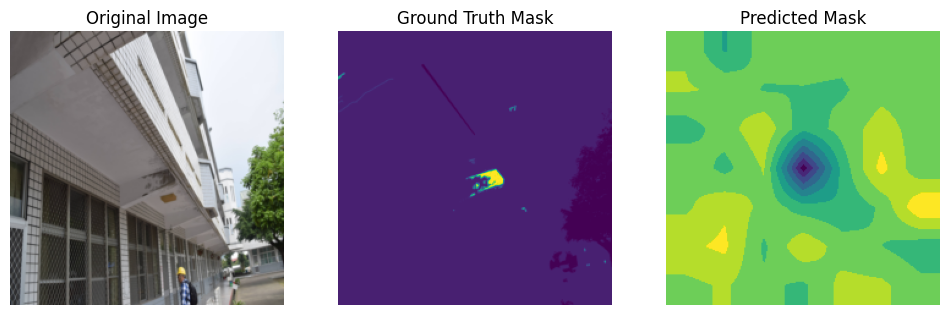

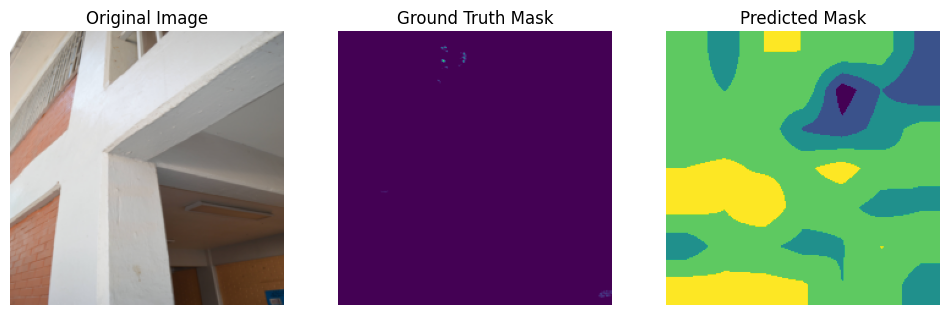

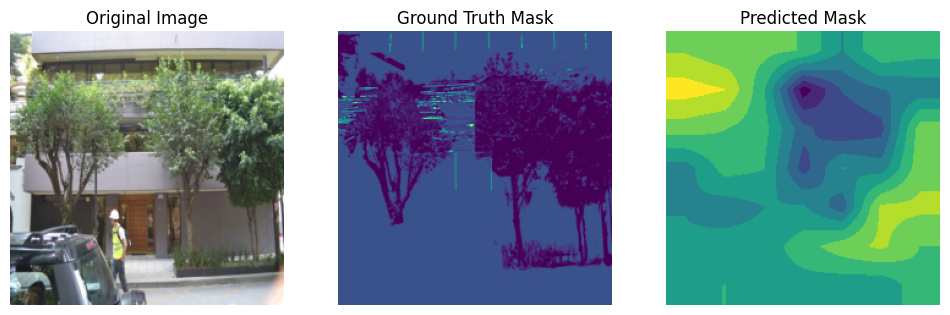

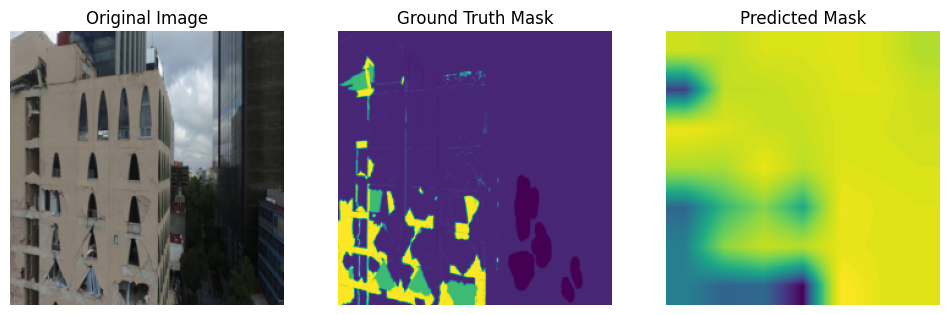

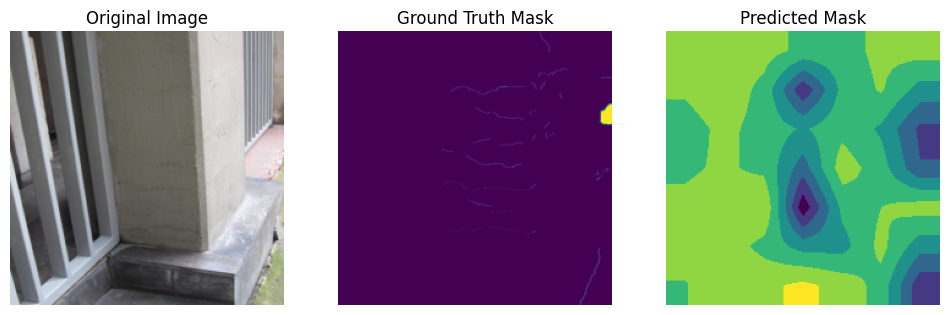

In [ ]:
import torchvision.transforms.functional as TF

# Load the trained model
model = DamageSegmentationModel()
model.load_state_dict(torch.load('/content/gdrive/My Drive/project DL/model-max-2.pth', map_location=torch.device('cpu')))
model.eval()
model.to(device)  # Move the model to the same device as the input data

# Function to generate predictions and create comparison plots
def generate_and_plot_images(model, dataloader, num_images=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Select random images from the dataset
    indices = np.random.choice(len(dataloader.dataset), num_images, replace=False)
    selected_images = [dataloader.dataset[i] for i in indices]

    # Plot original images, ground truth masks, and model predictions
    for i, (image, ground_truth_mask) in enumerate(selected_images):
        image = image.unsqueeze(0).to(device)
        ground_truth_mask = ground_truth_mask.unsqueeze(0).to(device)

        # Generate model prediction
        with torch.no_grad():
            model_output = model(image)

        # Apply sigmoid activation and convert to PIL Image for visualization
        predicted_mask = torch.sigmoid(model_output)
        predicted_mask_pil = TF.to_pil_image(predicted_mask.squeeze(0))

        # Plotting
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(TF.to_pil_image(image.cpu().squeeze(0)))
        plt.title("Original Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(TF.to_pil_image(ground_truth_mask.cpu().squeeze(0)))
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask_pil)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Generate and plot images
generate_and_plot_images(model, dataloader, num_images=5)

In [ ]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import confusion_matrix
from torchmetrics.functional import iou

def calculate_iou(y_true, y_pred):
    # Flatten the masks and convert them to numpy arrays
    y_true = y_true.view(-1).cpu().numpy()
    y_pred = y_pred.view(-1).cpu().numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate Intersection over Union
    intersection = np.diag(cm)
    union = np.sum(cm, axis=0) + np.sum(cm, axis=1) - intersection
    iou = intersection / union

    # Take the mean IoU excluding the background class
    mean_iou = np.mean(iou[1:])  # Exclude the background class (class 0)

    return mean_iou

def evaluate_model(model, dataloader, num_images=100):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    total_iou = 0.0
    num_samples = min(num_images, len(dataloader))

    with torch.no_grad():
        for i, (image, ground_truth_mask) in enumerate(dataloader):
            if i >= num_samples:
                break

            image = image.to(device)
            ground_truth_mask = ground_truth_mask.to(device)

            # Generate model prediction
            model_output = model(image)

            # Apply sigmoid activation to get probabilities
            predicted_mask = torch.sigmoid(model_output)

            # Convert to binary masks (0 or 1) based on a threshold (e.g., 0.5)
            predicted_mask_binary = (predicted_mask > 0.5).float()

            # Calculate IoU
            iou_value = iou(predicted_mask_binary, ground_truth_mask)
            total_iou += iou_value.item()

    mean_iou = total_iou / num_samples

    return mean_iou

# Evaluate the model on 100 images
mean_iou = evaluate_model(model, dataloader, num_images=100)
print(f'Mean IoU for 100 images: {mean_iou:.4f}')

ImportError: ignored